In [1]:
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer

from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.neighbors import KNeighborsClassifier

from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import statsmodels.api as sm

import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from dateutil.relativedelta import relativedelta
from datetime import date

from IPython.display import display_html

In [2]:
from mlxtend.plotting import plot_decision_regions

import math

from sklearn.dummy import DummyClassifier

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [3]:
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.utils.class_weight import compute_class_weight

In [4]:
#import pydotplus
#import graphviz
#import pickle

In [5]:
#!pip install nb_black
#%load_ext nb_black

In [6]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [7]:
# y_pred is an array of predictions
def bestThresshold(y_true,y_pred):
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_true, np.array(y_pred)>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    return best_score , best_thresh


In [8]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=20):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(20)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()
    
# from TowardsDataScience.com by Shaked Zychlinski
# URL: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

## Pulling in weather data
from Openweather.org. URL: https://home.openweathermap.org/history_bulks/new

In [9]:
weather = pd.read_csv('http://history.openweathermap.org/storage/2190c766ac5f9f46f1c8c871c49523ec.csv')
weather.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1461888000,2016-04-29 00:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.80,73.27,73.40,75.96,...,220,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
1,1461891600,2016-04-29 01:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.85,72.05,73.40,76.05,...,220,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
2,1461895200,2016-04-29 02:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.81,73.09,73.40,75.78,...,240,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
3,1461898800,2016-04-29 03:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.65,72.23,72.76,75.67,...,230,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
4,1461902400,2016-04-29 04:00:00 +0000 UTC,-10800,Vitoria,-20.297618,-40.295777,73.56,71.44,72.60,75.44,...,230,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n


In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   986 non-null    int64  
 1   dt_iso               986 non-null    object 
 2   timezone             986 non-null    int64  
 3   city_name            986 non-null    object 
 4   lat                  986 non-null    float64
 5   lon                  986 non-null    float64
 6   temp                 986 non-null    float64
 7   feels_like           986 non-null    float64
 8   temp_min             986 non-null    float64
 9   temp_max             986 non-null    float64
 10  pressure             986 non-null    int64  
 11  sea_level            0 non-null      float64
 12  grnd_level           0 non-null      float64
 13  humidity             986 non-null    int64  
 14  wind_speed           986 non-null    float64
 15  wind_deg             986 non-null    int

In [11]:
weather["dt_iso"] = weather["dt_iso"].map(lambda x: str(x)[:-4])

In [12]:
# changing to datetime format

weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

In [13]:
# keeping important weather data for merge

weather_drop_cols = ['dt', 'timezone', 'city_name', 'lat', 'lon', 'temp',
       'temp_min', 'temp_max', 'pressure', 'sea_level',
       'grnd_level', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all', 'weather_id',
       'weather_description', 'weather_icon']
weather = weather.drop(columns=weather_drop_cols)

In [14]:
# changing label name for merging later

weather = weather.rename(columns={'dt_iso':'AppointmentDay'})

In [15]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   AppointmentDay  986 non-null    datetime64[ns, UTC]
 1   feels_like      986 non-null    float64            
 2   weather_main    986 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 23.2+ KB


In [16]:
weather.head()

,AppointmentDay,feels_like,weather_main
0,2016-04-29 00:00:00+00:00,73.27,Clouds
1,2016-04-29 01:00:00+00:00,72.05,Clouds
2,2016-04-29 02:00:00+00:00,73.09,Clouds
3,2016-04-29 03:00:00+00:00,72.23,Clouds
4,2016-04-29 04:00:00+00:00,71.44,Clouds


In [17]:
weather.feels_like = weather.feels_like.astype(int).round(0)

In [18]:
weather.weather_main.value_counts()

Clouds          574
Clear           390
Rain             11
Mist              5
Smoke             4
Fog               1
Thunderstorm      1
Name: weather_main, dtype: int64

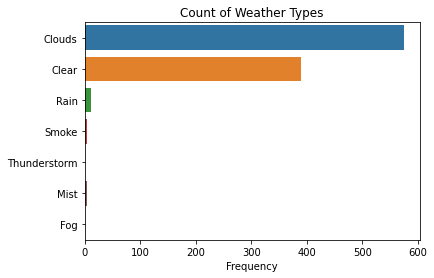

In [19]:
sns.countplot(y='weather_main', data=weather)
plt.title('Count of Weather Types')
plt.xlabel('Frequency')
plt.ylabel('')
plt.show()

## Pulling in main appointment data

In [20]:
df = pd.read_csv('noshowappointments.csv')

This dataset has information about 110527 medical appointments in Vitoria Brazil from 29 April - 8 June 2016
The goal is to predict whether a patient will show up to their appointment. 

Missed appointments cost the US 150b each year. https://www.hcinnovationgroup.com/clinical-it/article/13008175/missed-appointments-cost-the-us-healthcare-system-150b-each-year

Data Dictionary: 

PatientId -Identification of a patient

AppointmentID - Identification of each appointment

Gender - Male or Female

AppointmentDay - The day of the actual appointment, when they have to visit the doctor

ScheduledDay - The day someone called or registered the appointment, this is before appointment of course.

Age - Age of the patient.

Neighborhood - Where the appointment takes place.

Scholarship - True of False. Whether or not the school age patient is participating in Bolsa Famila which pays a stipend based on meeting certain metrics like class attendance or getting vaccinated. 
https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

Hypertension - True or False

Diabetes -True or False

Alcoholism - True or False

Disability - 0-4. 0 is no disability and remaining numbers indicate how many disabilities the patient has

Reminder - True or False. 1 or more messages sent to the patient

No-show - True or False

# Things to do:
  *  Break down both dates into hour and day of week to see if there is anything significant with target.
      
      No hour data in appointment day but we do have interval in days between day scheduled and day of appointment.
  
  
  *  Check for outliers and missing data.
      
      None but we do have imbalanced classes.
  
  
  *  Investigate whether any variables can be mixed such as Hypertenion and Diabetes.
  
  
  *  Attempt to bring in weather for the appointment day since that is likely to have an impact on target.
  
      Done. However, there is only one rain day during the appointment times and temp is mild so it's not useful here.
      
  
  *  Determine which vars are correlated with target and drop those not important.
  
      According to XGBoost, the least important features are 
  
  
  *  Find important variables that help predict whether a patient shows to their appointment. 
  
  
  *  Compare different models. KNN is best using continous data so it's ruled out here. 

In [21]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [22]:
df.shape

(110527, 14)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [24]:
df['PatientId'].nunique()

6100

In [25]:
df['AppointmentID'].nunique()

110527

In [26]:
#dropping appointmentID

df = df.drop(columns = 'AppointmentID')

In [27]:
# cleaning column names

df['Neighborhood'] = df['Neighbourhood']
df = df.drop(columns=['Neighbourhood'])

df['Hypertension'] = df['Hipertension']
df = df.drop(columns=['Hipertension'])

df['Disability'] = df['Handcap']
df = df.drop(columns=['Handcap'])

df['Reminder'] = df['SMS_received']
df = df.drop(columns=['SMS_received'])

df['show'] = df['No-show']
df = df.drop(columns=['No-show'])

In [28]:
# changing target to binary
df['show'] = df.show.transform(lambda x: int(x =='Yes'))

In [29]:
df.show.value_counts()

0    88208
1    22319
Name: show, dtype: int64

Converting to datetime data type and creating day of week variables.

In [30]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

In [31]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [32]:
# creating date variables from ScheduleDay

df["sch_weekday_num"] = df["ScheduledDay"].dt.weekday
df["sch_weekday_name"] = df["ScheduledDay"].dt.day_name()

In [33]:
# creating date variables from AppointmentDay

df["appt_weekday_num"] = df["AppointmentDay"].dt.weekday
df["appt_weekday_name"] = df["AppointmentDay"].dt.day_name()

In [34]:
df['has_diabetes_and_hyper'] = df['Hypertension'] * df['Diabetes']

In [35]:
# creating interval in days between scheduled and appointment days

df['day_diff']=(df['AppointmentDay'] - df['ScheduledDay']).dt.days

#df_merge['day_diff'] = df_merge['AppointmentDay'] - df_merge['ScheduledDay']
#df_merge['day_diff'] = df_merge['day_diff'] / np.timedelta64(1,'D')

In [36]:
df.day_diff.value_counts()

-1      38567
 1       6725
 3       5290
 0       5213
 6       4906
        ...  
 116        1
 124        1
 125        1
 126        1
 131        1
Name: day_diff, Length: 129, dtype: int64

There are no hours in the AppointmentDay datestamp resulting in negative day differences when AppointmentDay and ScheduleDay are the same day. Will remove rows with negative day diff since replacing with the mean with highly skewed data may distort an analysis of day_diff. Dropping removes 38567 observations out of over 110 observations.

In [37]:
df = df[df['day_diff'] >= 0 ]

In [38]:
# Scatter plot for the relationship between ScheduledDay and AppointmentDay
#sns.scatterplot(x="ScheduledDay",y="AppointmentDay", hue='show')
#plt.title("Relationship between ScheduledDay and AppointmentDay")
#plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71960 entries, 5 to 110526
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   PatientId               71960 non-null  float64            
 1   Gender                  71960 non-null  object             
 2   ScheduledDay            71960 non-null  datetime64[ns, UTC]
 3   AppointmentDay          71960 non-null  datetime64[ns, UTC]
 4   Age                     71960 non-null  int64              
 5   Scholarship             71960 non-null  int64              
 6   Diabetes                71960 non-null  int64              
 7   Alcoholism              71960 non-null  int64              
 8   Neighborhood            71960 non-null  object             
 9   Hypertension            71960 non-null  int64              
 10  Disability              71960 non-null  int64              
 11  Reminder                71960 non-null  

## Merging df and weather dataframes

In [40]:
df_merge = pd.merge(df, weather, on='AppointmentDay', how='left', indicator=True)

In [41]:
df_merge.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,...,show,sch_weekday_num,sch_weekday_name,appt_weekday_num,appt_weekday_name,has_diabetes_and_hyper,day_diff,feels_like,weather_main,_merge
0,9.600000e+13,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,0,0,REPÚBLICA,1,...,0,2,Wednesday,4,Friday,0,1,73,Clouds,both
1,7.340000e+14,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,0,0,0,GOIABEIRAS,0,...,1,2,Wednesday,4,Friday,0,1,73,Clouds,both
2,3.450000e+12,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,0,0,0,GOIABEIRAS,0,...,1,2,Wednesday,4,Friday,0,1,73,Clouds,both
3,7.810000e+13,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,0,0,0,CONQUISTA,0,...,0,2,Wednesday,4,Friday,0,1,73,Clouds,both
4,7.350000e+14,F,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,0,0,0,NOVA PALESTINA,0,...,0,2,Wednesday,4,Friday,0,1,73,Clouds,both


In [42]:
df_merge._merge.value_counts()

both          71960
right_only        0
left_only         0
Name: _merge, dtype: int64

In [43]:
df_merge.weather_main.value_counts()

Clear     36698
Clouds    35262
Name: weather_main, dtype: int64

In [44]:
# inserting weather on May 20th because there is no hour in Appointment Day to merge on. It rained all day on 20 May
# and is the only day it rained during the period in the dataset, 29 April to 8 June 2016. 
df_merge.loc[df_merge['AppointmentDay'] == '2016-05-20 00:00:00+00:00', 'weather_main'] = 'Rain'

#### According to XGBoost feature selection below, the only weather variable, feels_like, scored a zero so I did not use weather data as I had hoped. This might be because, during the 6 weeks time of the dataset, it rained only 1 day affecting just over 3000 patients and apparently not enough to have an impact. Perhaps looking at data over a year timespan would be more telling.

## Plotting variables with target, no_show

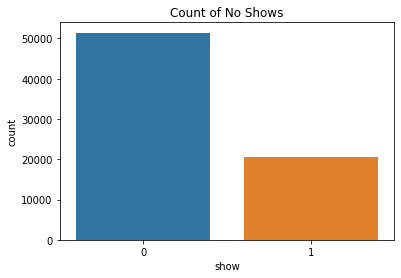

In [45]:
# positive class is a no show

sns.countplot(x=df['show'])
plt.title('Count of No Shows')
plt.show()

In [46]:
total_app = df.show.count()

In [47]:
totalno = df.query('show =="1"')['show'].count()
totalyes = df.query('show =="0"')['show'].count()
print(totalno)
print(totalyes)

20523
51437


In [48]:
prop_no = 20521/71958
prop_yes = 51437/71958
print(prop_no)
print(prop_yes)

0.2851802440312404
0.7148197559687596


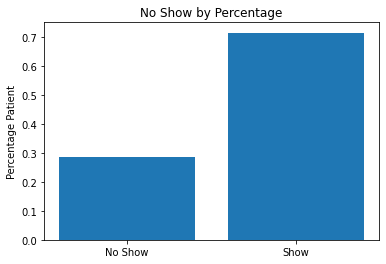

In [49]:
#Plotting the percentage of patient show up/No show up
plt.bar([1,2], [prop_no, prop_yes], tick_label=['No Show', 'Show'])
plt.title('No Show by Percentage')
plt.ylabel('Percentage Patient');

In [50]:
# target is imbalanced at about 70, 30

df.show.value_counts(normalize=True)

0    0.7148
1    0.2852
Name: show, dtype: float64

In [51]:
df['show'].value_counts()

0    51437
1    20523
Name: show, dtype: int64

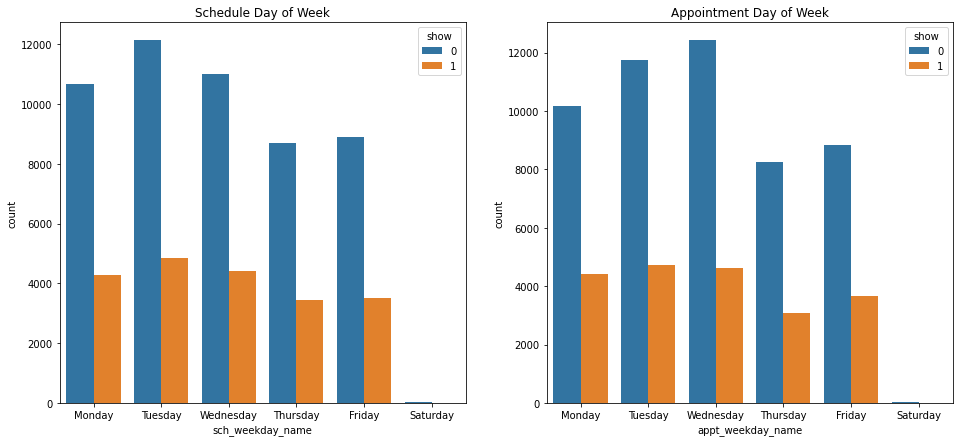

In [52]:
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
sns.countplot(x='sch_weekday_name',hue='show',data=df, order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Schedule Day of Week')

plt.subplot(1,2,2)
sns.countplot(x='appt_weekday_name',hue='show',data=df, order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Appointment Day of Week')
plt.show()

In [53]:
crosstable = pd.crosstab(df["appt_weekday_name"], df["show"])
crosstable

show,0,1
appt_weekday_name,,
Friday,8842,3674
Monday,10176,4405
Saturday,22,9
Thursday,8237,3089
Tuesday,11743,4719
Wednesday,12417,4627


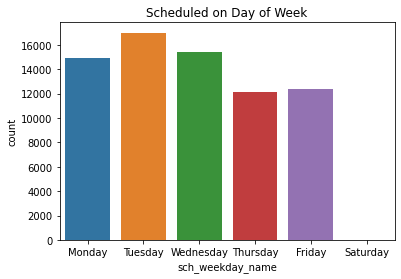

In [54]:
# Tuesday is the busiest day for scheduling appointments followed by Wednesday

sns.countplot(x=df['sch_weekday_name'], order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Scheduled on Day of Week')
plt.show()

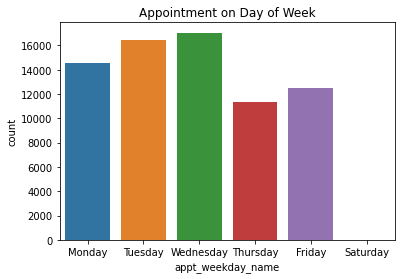

In [55]:
# Wednesday has the most appointments followed by Tuesday

sns.countplot(x=df['appt_weekday_name'], order=['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday'])
plt.title('Appointment on Day of Week')
plt.show()

From pairplot, we can see that variables do not have a linear relationship with the target.

In [56]:
#sns.pairplot(df)
#plt.show()

## Looking at scheduled time and appointment time

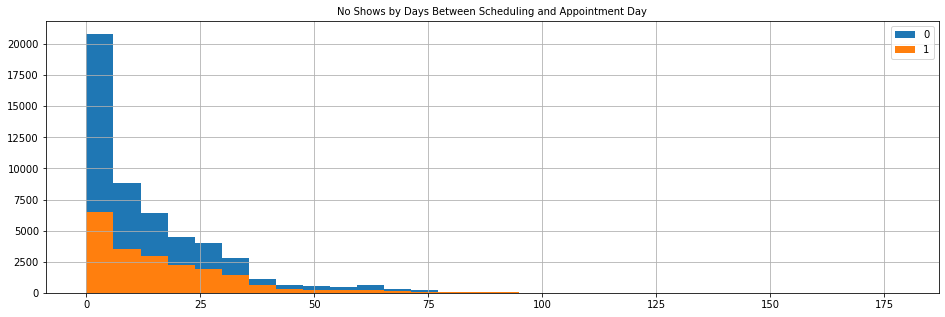

In [57]:
# plotting time betweeen scheduling and appointment day on no shows which seems to show that the less time difference
# the less no shows

plt.figure(figsize=(16,5))
df.groupby('show')['day_diff'].hist(bins=30)
plt.title('No Shows by Days Between Scheduling and Appointment Day', size = '10')
plt.legend(df.show.unique());

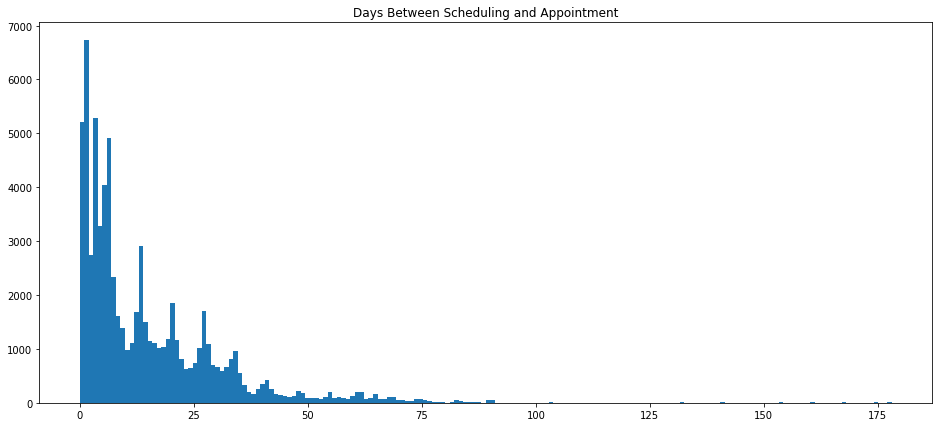

In [58]:
plt.figure(figsize=(16,7))
plt.hist(x='day_diff', data=df, bins = 180)
plt.title('Days Between Scheduling and Appointment')
plt.show()

We can see that as the time span between making the appointment and showing up increases so does the proportion of no shows.

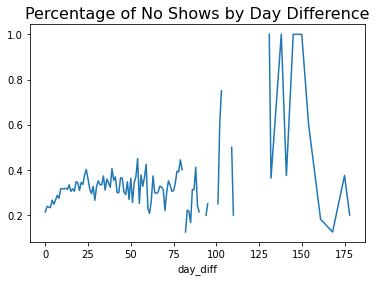

In [59]:
ratio = df[df['show'] == 1].groupby(['day_diff']).size()/df.groupby(['day_diff']).size()
ratio.plot()
plt.title('Percentage of No Shows by Day Difference', size='16')
plt.show()

## Age and No Show

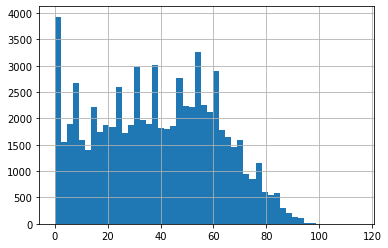

In [60]:
df.Age.hist(bins=50)
plt.show()

In [61]:
df.Age.value_counts()

0      2131
52     1144
53     1132
56     1132
57     1126
       ... 
98        5
96        5
100       4
115       4
102       1
Name: Age, Length: 102, dtype: int64

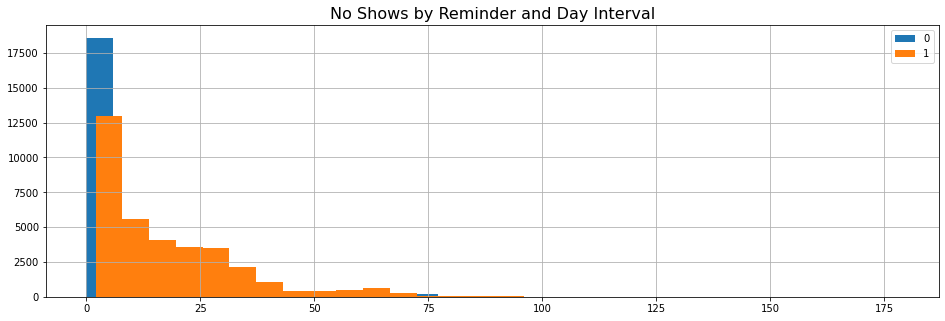

In [62]:
plt.figure(figsize=(16,5))
df.groupby('Reminder')['day_diff'].hist(bins=30)
plt.title('No Shows by Reminder and Day Interval', size = '16')
plt.legend(df.show.unique());

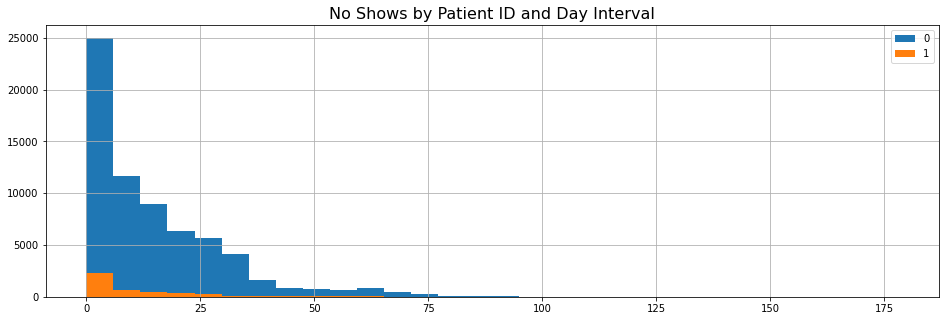

In [63]:
plt.figure(figsize=(16,5))
df.groupby('has_diabetes_and_hyper')['day_diff'].hist(bins=30)
plt.title('No Shows by Patient ID and Day Interval', size = '16')
plt.legend(df.show.unique());

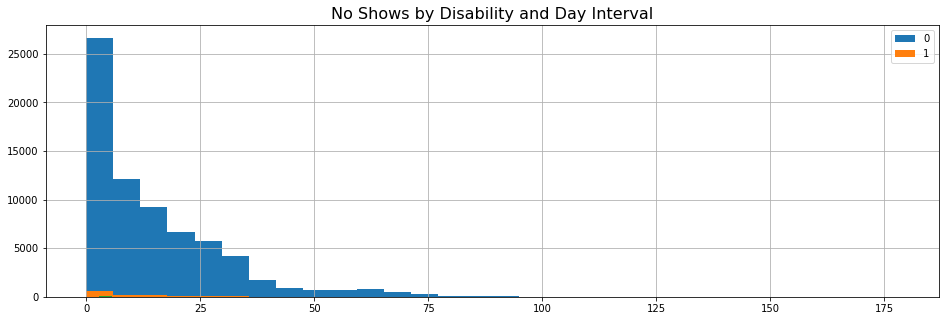

In [64]:
plt.figure(figsize=(16,5))
df.groupby('Disability')['day_diff'].hist(bins=30)
plt.title('No Shows by Disability and Day Interval', size = '16')
plt.legend(df.show.unique());

## No show and Neighborhood

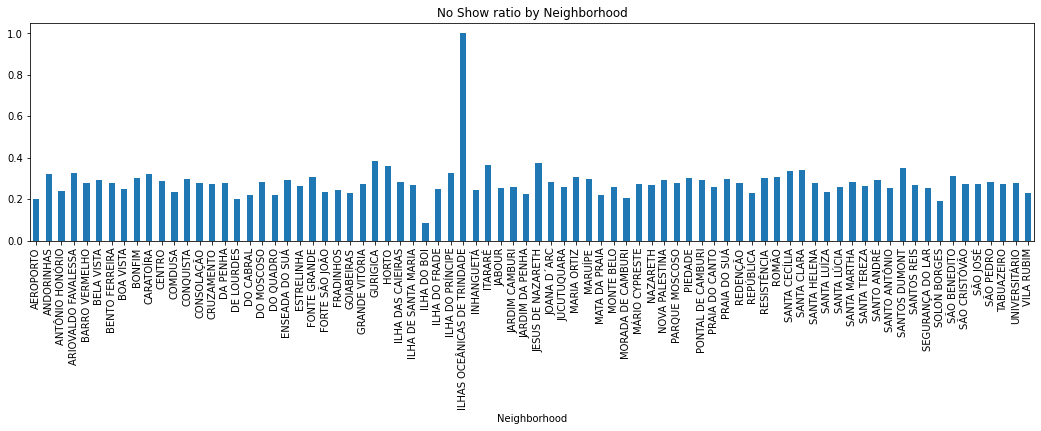

In [65]:
#Plotting ratio between showing up and all patients for every neighbourhood

ratio = df[df.show == 1].groupby('Neighborhood').size()/df.groupby('Neighborhood').size()
plt.figure(figsize=(18,4))
plt.title('No Show ratio by Neighborhood')
ratio.plot(kind='bar');

In [66]:
df[df.show == 1].groupby('Neighborhood').size().nsmallest()

Neighborhood
AEROPORTO                       1
ILHA DO BOI                     2
ILHA DO FRADE                   2
ILHAS OCEÂNICAS DE TRINDADE     2
PONTAL DE CAMBURI              12
dtype: int64

In [67]:
df.groupby('Neighborhood').size().nsmallest()

Neighborhood
ILHAS OCEÂNICAS DE TRINDADE     2
AEROPORTO                       5
ILHA DO FRADE                   8
ILHA DO BOI                    23
PONTAL DE CAMBURI              41
dtype: int64

In [68]:
# dropping outlier neighborhoods or those with equal patients and no shows

df = df[(df.Neighborhood !='ILHAS OCEÂNICAS DE TRINDADE')]
df.Neighborhood.nunique()

79

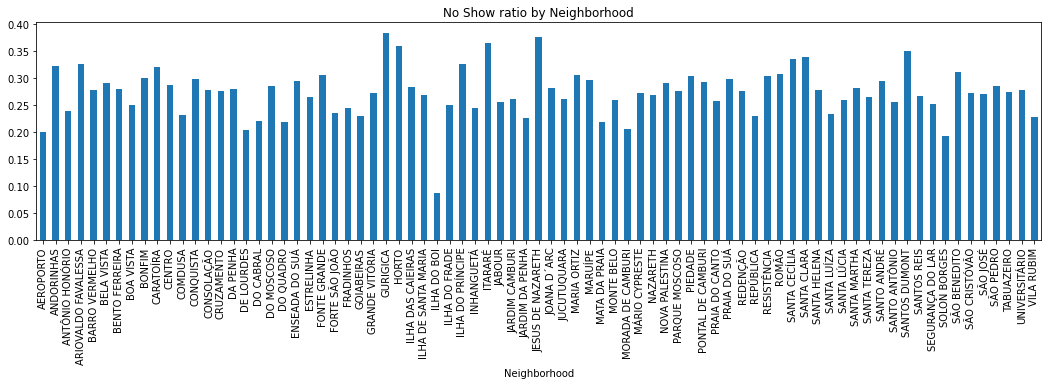

In [69]:
ratio = df[df.show == 1].groupby('Neighborhood').size()/df.groupby('Neighborhood').size()
plt.figure(figsize=(18,4))
plt.title('No Show ratio by Neighborhood')
ratio.plot(kind='bar');

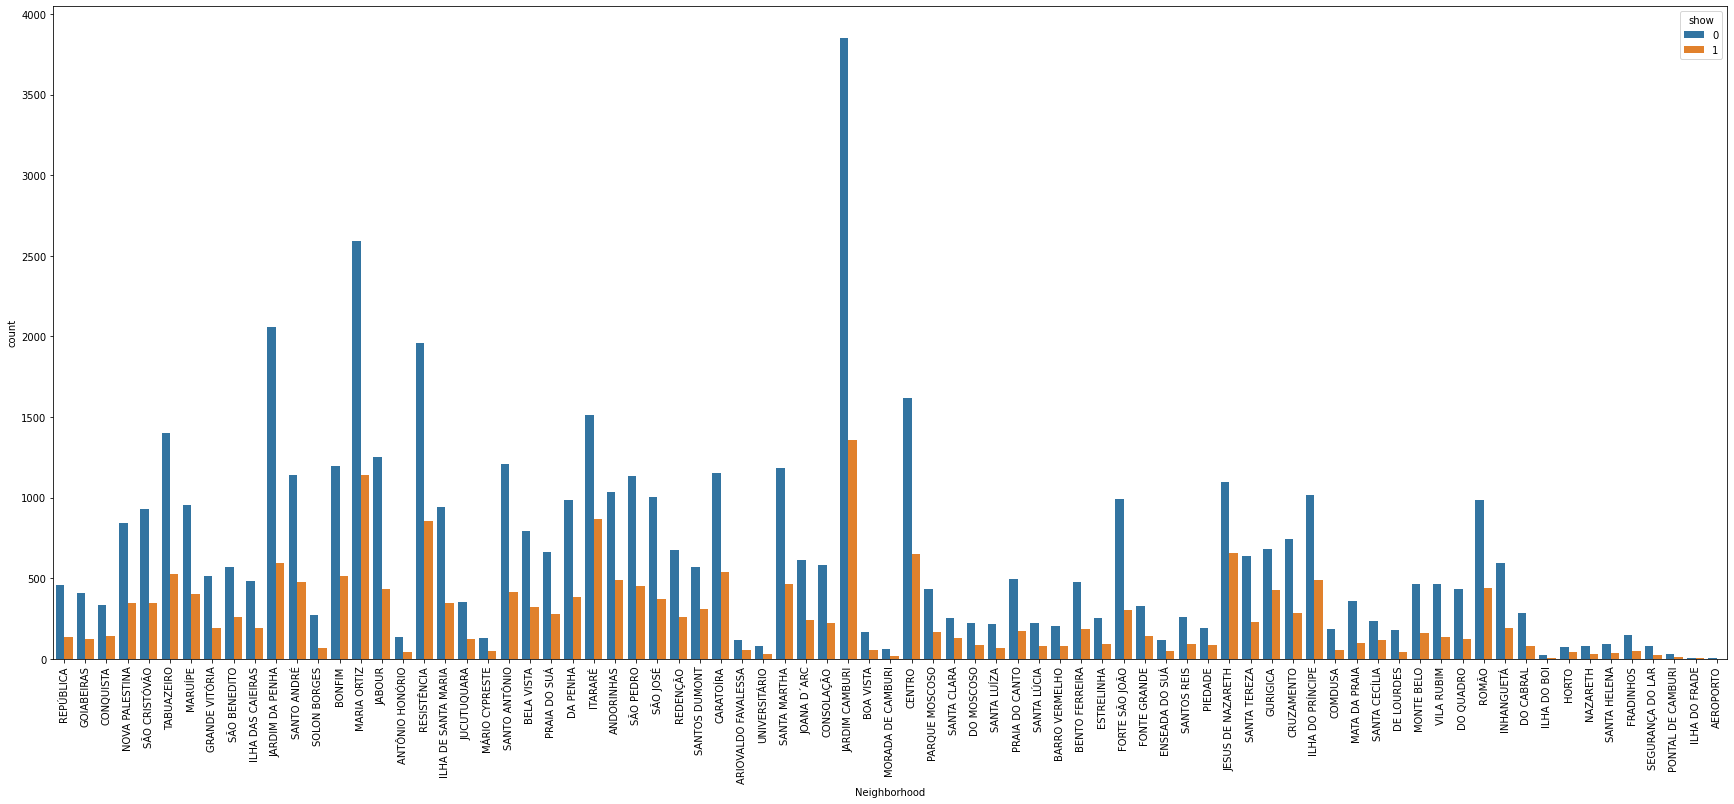

In [70]:
plt.figure(figsize=(30,12))
fig = sns.countplot(x='Neighborhood',hue='show',data=df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

In [71]:
print(df['Neighborhood'].value_counts(sort=True).nlargest(5))
print(df['Neighborhood'].value_counts(sort=True).nsmallest(5))

JARDIM CAMBURI     5213
MARIA ORTIZ        3730
RESISTÊNCIA        2818
JARDIM DA PENHA    2655
ITARARÉ            2381
Name: Neighborhood, dtype: int64
AEROPORTO             5
ILHA DO FRADE         8
ILHA DO BOI          23
PONTAL DE CAMBURI    41
MORADA DE CAMBURI    78
Name: Neighborhood, dtype: int64


In [72]:
# creating binary for disability

df['disability'] = df.Disability.transform(lambda x: int(x > 0))

In [73]:
df.disability.value_counts()

0    70651
1     1307
Name: disability, dtype: int64

In [74]:
df['is_male'] = df.Gender.transform(lambda x: int(x =='M'))

In [75]:
df.is_male.value_counts()

0    48069
1    23889
Name: is_male, dtype: int64

In [76]:
df['show'].groupby(df['is_male']).value_counts(normalize=True)

is_male  show
0        0       0.715555
         1       0.284445
1        0       0.713341
         1       0.286659
Name: show, dtype: float64

In [77]:
df.show.value_counts()

0    51437
1    20521
Name: show, dtype: int64

In [78]:
df = df.drop(columns = ['Gender', 'Disability'])

In [79]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

Neighborhood
79
sch_weekday_name
6
appt_weekday_name
6


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71958 entries, 5 to 110526
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   PatientId               71958 non-null  float64            
 1   ScheduledDay            71958 non-null  datetime64[ns, UTC]
 2   AppointmentDay          71958 non-null  datetime64[ns, UTC]
 3   Age                     71958 non-null  int64              
 4   Scholarship             71958 non-null  int64              
 5   Diabetes                71958 non-null  int64              
 6   Alcoholism              71958 non-null  int64              
 7   Neighborhood            71958 non-null  object             
 8   Hypertension            71958 non-null  int64              
 9   Reminder                71958 non-null  int64              
 10  show                    71958 non-null  int64              
 11  sch_weekday_num         71958 non-null  

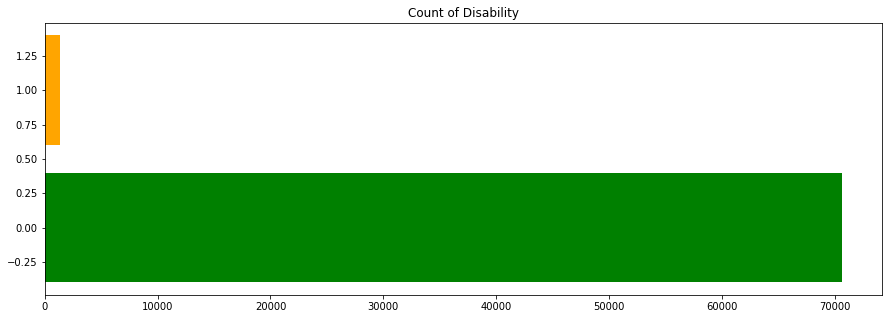

In [81]:
plt.figure(figsize=(15,5))
plt.barh(df.groupby("disability")["disability"].count().index, 
        df.groupby("disability")["disability"].count(), 
        color=["green","orange"])
plt.title("Count of Disability")
plt.show()

In [82]:
df.appt_weekday_num.value_counts()

2    17044
1    16462
0    14581
4    12514
3    11326
5       31
Name: appt_weekday_num, dtype: int64

In [83]:
# creating columns for preprocessing

drop_cats = [42500000000000,'JARDIM CAMBURI', 1, 2]

cat_cols = ['PatientId', 'Neighborhood', 'sch_weekday_num', 'appt_weekday_num']

bin_cols = ['is_male','Scholarship', 'Alcoholism', 'Reminder', 'has_diabetes_and_hyper',
            'disability']

num_cols = ['Age', 'day_diff']

Looking at categorical data with our target, only two stand out. Those who get reminders have a greater percentage of showing up. Also, those who have a scholarship have a slightly higher percentage of not showing up. The interaction between hypertension and diabetes appears unchanged from either of the variables alone. 

show,0,1
is_male,,
0,0.715555,0.284445
1,0.713341,0.286659


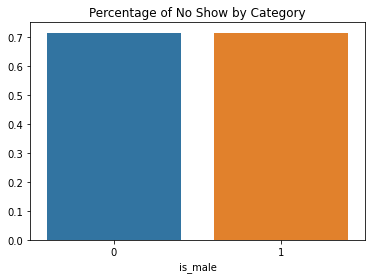

show,0,1
Scholarship,,
0,0.721415,0.278585
1,0.650277,0.349723


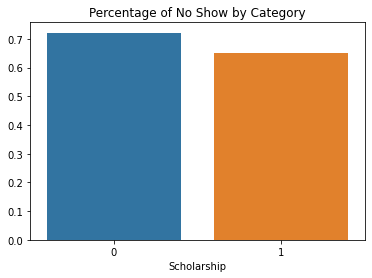

show,0,1
Alcoholism,,
0,0.716266,0.283734
1,0.659166,0.340834


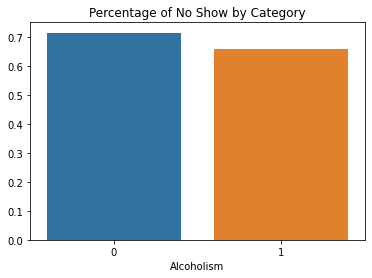

show,0,1
Reminder,,
0,0.705642,0.294358
1,0.724255,0.275745


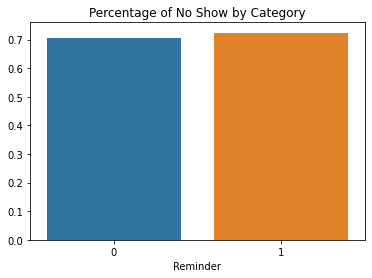

show,0,1
has_diabetes_and_hyper,,
0,0.712038,0.287962
1,0.757562,0.242438


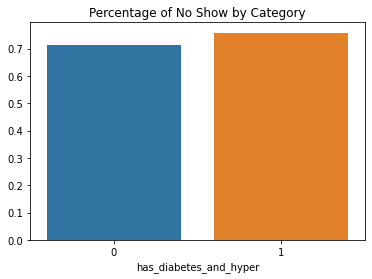

show,0,1
disability,,
0,0.714272,0.285728
1,0.744453,0.255547


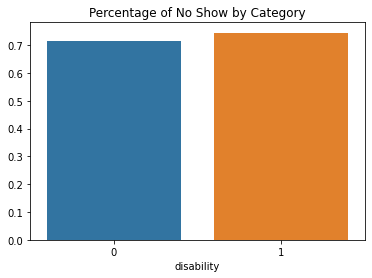

In [84]:
for bin_col in bin_cols:
    display(pd.crosstab(df[bin_col], df["show"], normalize="index"))
        
    Sch_ratio = df[df.show == 0].groupby(df[bin_col]).size()/df.groupby(df[bin_col]).size()
    ax = sns.barplot(x=Sch_ratio.index, y=Sch_ratio)
    ax.set_title("Percentage of No Show by Category", size='12')
    plt.show()

Visualing numerical data with target. Younger ages appear to miss their appointment more than older patients. It also looks like more days between scheduling the appointment and the appointment day has more no_shows. 

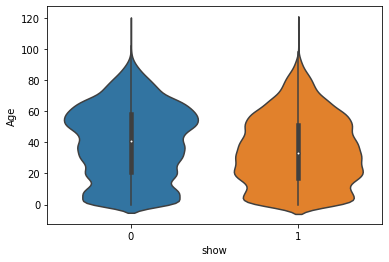

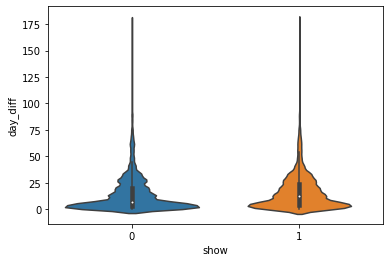

In [85]:
for num_col in num_cols:
    sns.violinplot(x=df["show"], y=df[num_col])
    plt.show()

In [86]:
df.show.value_counts()

0    51437
1    20521
Name: show, dtype: int64

In [87]:
df.AppointmentDay.dt.day.value_counts().sort_index()

1     2937
2     5632
3     5368
4     2811
5     2740
6     5586
7     2871
8     2942
9     2849
10    2731
11    2952
12    2866
13    2606
14      31
16    2997
17    2860
18    2916
19    2876
20    2534
24    2445
25    2486
29    2182
30    2874
31    2866
Name: AppointmentDay, dtype: int64

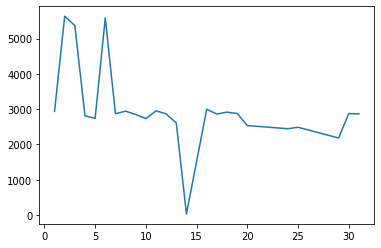

In [88]:
df.AppointmentDay.dt.day.value_counts().sort_index().plot()

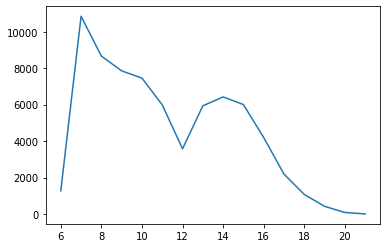

In [89]:
df.ScheduledDay.dt.hour.value_counts().sort_index().plot()

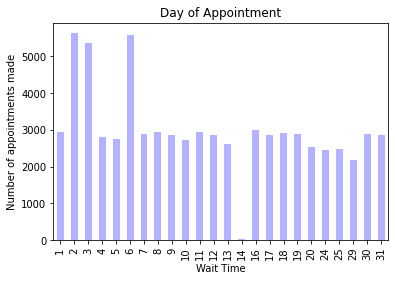

In [90]:
# grouping the appointments by day and count

df.groupby(df["AppointmentDay"].dt.day)["AppointmentDay"].count().plot(kind="bar", color='b', alpha=0.3)
plt.title('Day of Appointment')
plt.xlabel('Wait Time')
plt.ylabel('Number of appointments made')
plt.show()

,PatientId,proportion,count
3837,2.150000e+13,0.338710,62
3894,2.720000e+13,0.177419,62
3997,3.850000e+13,0.200000,65
4027,4.250000e+13,0.227273,66
4238,6.560000e+13,0.229508,61


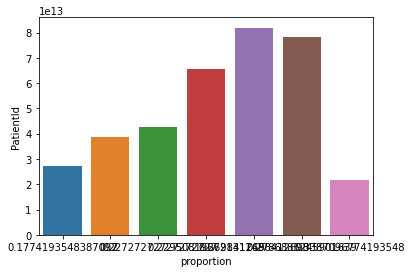

In [91]:
returning = df[["PatientId", "show"]]

show_rate_by_patient = returning.groupby("PatientId").agg(["mean", "count"])
show_rate_by_patient.columns = ["proportion", "count"]
show_rate_by_patient = show_rate_by_patient.reset_index()

# Removing 1-offs that might skew pattern
viz_df = show_rate_by_patient[show_rate_by_patient["count"] > 60]
display(viz_df.head())

sns.barplot(x="proportion", y="PatientId", data=viz_df)
plt.show()

In [92]:
df.head()

,PatientId,ScheduledDay,AppointmentDay,Age,Scholarship,Diabetes,Alcoholism,Neighborhood,Hypertension,Reminder,show,sch_weekday_num,sch_weekday_name,appt_weekday_num,appt_weekday_name,has_diabetes_and_hyper,day_diff,disability,is_male
5,9.600000e+13,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,0,0,REPÚBLICA,1,0,0,2,Wednesday,4,Friday,0,1,0,0
6,7.340000e+14,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,0,0,0,GOIABEIRAS,0,0,1,2,Wednesday,4,Friday,0,1,0,0
7,3.450000e+12,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,0,0,0,GOIABEIRAS,0,0,1,2,Wednesday,4,Friday,0,1,0,0
9,7.810000e+13,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,0,0,0,CONQUISTA,0,0,0,2,Wednesday,4,Friday,0,1,0,0
10,7.350000e+14,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,0,0,0,NOVA PALESTINA,0,0,0,2,Wednesday,4,Friday,0,1,0,0


## Model Prep

In [93]:
# creating columns for preprocessing

drop_cats = [42500000000000,'JARDIM CAMBURI', 1, 2]

cat_cols = ['PatientId', 'Neighborhood', 'sch_weekday_num', 'appt_weekday_num']

bin_cols = ['is_male','Scholarship', 'Alcoholism', 'Reminder', 'has_diabetes_and_hyper',
            'disability']

num_cols = ['Age', 'day_diff']

In [94]:
X = df.drop(columns=["show", 'sch_weekday_name', 'appt_weekday_name','Diabetes', 'Hypertension',
                          'ScheduledDay', 'AppointmentDay'])
y = df["show"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [95]:
# fmt: off
preprocessing = ColumnTransformer([
    ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='passthrough')
# fmt: on

In [96]:
# fmt: off
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('xgb', XGBClassifier(use_label_encoder=False))
    #("model", RandomForestClassifier())
])
# fmt: on

In [97]:
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

[16:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train score: 0.6305110655595316
Test score: 0.6287520844913841


In [98]:
# pipline.predict only requires X, not y
y_pred = pipeline.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_No_show"],
    columns=["pred_show", "pred_No_show"],
)
# print(confusion_df)
display(confusion_df)

print(classification_report(y_test, y_pred))

,pred_show,pred_No_show
actual_show,8354,1934
actual_No_show,3409,695


              precision    recall  f1-score   support

           0       0.71      0.81      0.76     10288
           1       0.26      0.17      0.21      4104

    accuracy                           0.63     14392
   macro avg       0.49      0.49      0.48     14392
weighted avg       0.58      0.63      0.60     14392



In [99]:
# comparing to a dummy classifier
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.7148415786548082

In [100]:
y_pred = dummy.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_No_show"],
    columns=["pred_show", "pred_No_show"],
)
# print(confusion_df)
display(confusion_df)

print(classification_report(y_test, y_pred))

,pred_show,pred_No_show
actual_show,10288,0
actual_No_show,4104,0


              precision    recall  f1-score   support

           0       0.71      1.00      0.83     10288
           1       0.00      0.00      0.00      4104

    accuracy                           0.71     14392
   macro avg       0.36      0.50      0.42     14392
weighted avg       0.51      0.71      0.60     14392



C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Need to balance our data as below.  
The train and test score mirror the 80/20 imbalanced target data of no_shows.

In [101]:
# Isolating the 2 classes predictors
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

In [102]:
n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

In [103]:
n_0

41149

In [104]:
n_1

16417

In [105]:
n = 20000

In [106]:
# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n, replace=False, random_state=42)

# Sample minority class to have more observations
X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

In [107]:
# Re-combine data (using the downsampled X for majority class)
X_train_resample = pd.concat((X_train_1_sample, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n + [0] * n)

In [108]:
X_train_resample.shape

(40000, 12)

In [109]:
y_train_resample.mean()

0.5

In [110]:
params = {
    "xgb__colsample_bytree": [0.4],
    "xgb__max_depth": [2],
    "xgb__subsample": [0.5],
}

n_trees = 300
learning_rate = 2 / n_trees

In [111]:
xgb_pipeline_cv = GridSearchCV(pipeline, params, verbose=1, cv=2)
xgb_pipeline_cv.fit(X_train_resample, y_train_resample)

xgb_pipeline_cv.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[16:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[16:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished


[16:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'xgb__colsample_bytree': 0.4, 'xgb__max_depth': 2, 'xgb__subsample': 0.5}

In [112]:
#{'xgb__colsample_bytree': 0.5, 'xgb__max_depth': 3, 'xgb__subsample': 0.001} 59 60 acc=60 f1=71 37 pr=85 27 61 57

#{'xgb__colsample_bytree': 0.5, 'xgb__max_depth': 4, 'xgb__subsample': 0.001} accuracy .60

#{'xgb__colsample_bytree': 0.1, 'xgb__max_depth': 3, 'xgb__subsample': 1}  68 60 acc=61 f1=69 45 pr=91 31 56 79

#{'xgb__colsample_bytree': 0.1, 'xgb__max_depth': 4, 'xgb__subsample': 1}  61 61 acc=61 f1=86 29 61 62

#{'xgb__colsample_bytree': 0.5, 'xgb__max_depth': 4, 'xgb__subsample': 1}  70 61 acc=61 f1=70 45 pr=91 31 57 78

#{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__subsample': 1} 74 61 acc=62 f1=71 44 pr=91 31 59 75

#{'xgb__colsample_bytree': 1, 'xgb__max_depth': 3, 'xgb__subsample': 1} 68 60 acc=61 f1=69 45 pr= 91 31 56 79

#{'xgb__colsample_bytree': 1, 'xgb__max_depth': 4, 'xgb__subsample': 1} 71 65 acc=62 f1= 71 44 pr= 91 31 58 76

# {'xgb__colsample_bytree': 0.4, 'xgb__max_depth': 2, 'xgb__subsample': 0.5} 58 55 acc= 56 f1=65 39 pr= 74 32 58 52 

In [113]:
train_score = xgb_pipeline_cv.score(X_train_resample, y_train_resample)
test_score = xgb_pipeline_cv.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = xgb_pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_No_show"],
    columns=["pred_show", "pred_No_show"],
)
display(confusion_df)

print(classification_report(y_test, y_pred))

Train score: 0.547675
Test score: 0.539396887159533



,pred_show,pred_No_show
actual_show,5579,4709
actual_No_show,1920,2184


              precision    recall  f1-score   support

           0       0.74      0.54      0.63     10288
           1       0.32      0.53      0.40      4104

    accuracy                           0.54     14392
   macro avg       0.53      0.54      0.51     14392
weighted avg       0.62      0.54      0.56     14392



In [114]:
xgb_pipeline_cv.best_estimator_['xgb'].feature_importances_

array([0.02034771, 0.6795027 , 0.01107266, 0.01627687, 0.05811771,
       0.05313084, 0.06060914, 0.02587771, 0.03970959, 0.01773087,
       0.00619544, 0.01142883], dtype=float32)

In [115]:
importance_df = pd.DataFrame(
    {"feat": X_train.columns, "importance": xgb_pipeline_cv.best_estimator_['xgb'].feature_importances_}
)
importance_df.sort_values("importance", ascending=False)

,feat,importance
1,Age,0.679503
6,sch_weekday_num,0.060609
4,Neighborhood,0.058118
5,Reminder,0.053131
8,has_diabetes_and_hyper,0.039710
7,appt_weekday_num,0.025878
0,PatientId,0.020348
9,day_diff,0.017731
3,Alcoholism,0.016277
11,is_male,0.011429


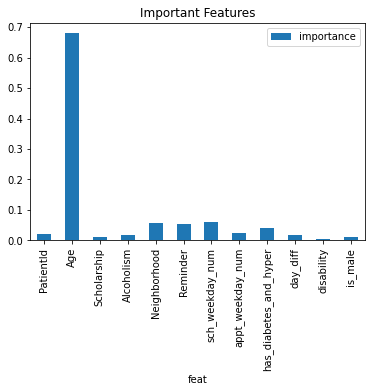

In [160]:
importance_df.plot(x='feat', y='importance', kind='bar')
plt.title('Important Features')
plt.show()

Using different hyperparams, the feature importances keep changing. It looks like Age, PatientId and Reminder are most important features. Day of the week the appoint was scheduled as well as the appointment itself are also important in the model. Feels_like and weather were both discarded as not important. 

Using hyperparams, {'xgb__colsample_bytree': 0.4, 'xgb__max_depth': 2, 'xgb__subsample': 0.5}, best features were Age, PatientId, sch_weekday_num, neighborhood, reminder, appt day, has diabetes and hypertension, sex, day difference, alcoholism, scholarship then disability. 

In [117]:
#best_model = pipeline_cv.best_estimator_
#with open("saved_model.pkl", "wb") as f:
#    pickle.dump(best_model, f)

In [118]:
xgb_errors = df.copy()
xgb_errors = xgb_errors.loc[y_test.index, :]

xgb_errors["y_true"] = y_test
xgb_errors["y_pred"] = y_pred

xgb_errors = xgb_errors[xgb_errors["y_true"] != xgb_errors["y_pred"]]

print(f'mean prob no show for errors using XGB: {xgb_errors["show"].mean()}')


mean prob no show for errors using XGB: 0.2896364459194449


In [119]:
#This function gets the best threshold for maximizing F1 score for binary predictions by
# iterating through possible threshold values to find the one that gives the best F1 score.

def bestThresshold(y_true,y_pred):
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_true, np.array(y_pred)>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    return best_score , best_thresh


In [120]:
bestThresshold(y_test,y_pred)

(0.3971992361553151, 0.1)

Some ways to improve model:
* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* Making more iterations
* Trying a different loss function
* Changing the structure of the weak learner by allowing more leaves in the tree or using other modifications

## Random Forest Classifier

In [121]:
# fmt: off
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ("rfc", RandomForestClassifier()),
])
# fmt: on

grid = {
    "rfc__n_estimators": [500],
    "rfc__max_depth": [2],
    "rfc__min_samples_leaf": [10],
}
learning_rate = 4 / n_trees

In [122]:
rfc_pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2)
rfc_pipeline_cv.fit(X_train_resample, y_train_resample)

rfc_pipeline_cv.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s finished


{'rfc__max_depth': 2, 'rfc__min_samples_leaf': 10, 'rfc__n_estimators': 500}

In [123]:
# {'rfc__max_depth': 2, 'rfc__min_samples_leaf': 15, 'rfc__n_estimators': 50} 64 56 acc=57 f1= 66 44 pr=75 33 59 50

#'rfc__max_depth': 7, 'rfc__min_samples_leaf': 10, 'rfc__n_estimators': 75} .67 .54 acc=.57 f1=66 and 44

#{'rfc__max_depth': 5, 'rfc__min_samples_leaf': 5, 'rfc__n_estimators': 75}  .66 .56 acc=56 f1=64 44

#{'rfc__max_depth': 4, 'rfc__min_samples_leaf': 7, 'rfc__n_estimators': 100}  66 54  acc=55 f1= 62 44

#{'rfc__max_depth': 3, 'rfc__min_samples_leaf': 7, 'rfc__n_estimators': 100}  66 54  acc=55 f1= 62 44

#{'rfc__max_depth': 3, 'rfc__min_samples_leaf': 10, 'rfc__n_estimators': 120}  66 54  acc=54 f1= 62 44  prec=94 29 46 88

# n_estimators: The more trees, the less likely the algorithm is to overfit. ...
# max_features: You should try reducing this number. ...
# max_depth: This parameter will reduce the complexity of the learned models, lowering over fitting risk.
# min_samples_leaf: Try setting these values greater than one.

In [124]:
train_score = rfc_pipeline_cv.score(X_train_resample, y_train_resample)
test_score = rfc_pipeline_cv.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = rfc_pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_no_show"],
    columns=["pred_show", "pred_no_show"],
)
display(confusion_df)

print(classification_report(y_test, y_pred))

Train score: 0.570625
Test score: 0.5369649805447471



,pred_show,pred_no_show
actual_show,5140,5148
actual_no_show,1516,2588


              precision    recall  f1-score   support

           0       0.77      0.50      0.61     10288
           1       0.33      0.63      0.44      4104

    accuracy                           0.54     14392
   macro avg       0.55      0.57      0.52     14392
weighted avg       0.65      0.54      0.56     14392



In [125]:
bestThresshold(y_test,y_pred)

(0.4371621621621622, 0.1)

## SVC

In [126]:
# fmt: off
pipeline = Pipeline([
    ("preprocessing", preprocessing), 
    ("svc", SVC(probability=True))
])
# fmt: on

grid = {
    "svc__kernel": ["rbf"],
    #"svc__degree": [4],
    "svc__C": [40],
}

svc_pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)

In [127]:
%%time
svc_pipeline_cv.fit(X_train_resample, y_train_resample)

print("Best params:")
print(svc_pipeline_cv.best_params_)

print(f"\ntrain score: {svc_pipeline_cv.score(X_train_resample, y_train_resample):.3f}")
print(f"test score: {svc_pipeline_cv.score(X_test, y_test):.3f}\n")

y_pred = svc_pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_no_show"],
    columns=["pred_show", "pred_no_show"],
)
display(confusion_df)

print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 40, 'svc__kernel': 'rbf'}

train score: 0.506
test score: 0.619



,pred_show,pred_no_show
actual_show,8020,2268
actual_no_show,3213,891


              precision    recall  f1-score   support

           0       0.71      0.78      0.75     10288
           1       0.28      0.22      0.25      4104

    accuracy                           0.62     14392
   macro avg       0.50      0.50      0.50     14392
weighted avg       0.59      0.62      0.60     14392

Wall time: 11min 51s


In [128]:
# C too high -> overfit
# C too low  -> underfit

# kernal selects the hyperplace. only the poly kernal uses a degree
# gamma is a parameter for non linear hyperplanes. higher gamma tries to exactly fit the training data set
# C is penalty parameter of the error term and controls trade off between smooth decision boundary and classifying the training points correctly
# degree is degree of the polynomial, 'poly' used the find the hyperplace to split the data

In [129]:
#{'svc__C': 1.0, 'svc__degree': 2, 'svc__kernel': 'rbf'} 66 57 acc=58 f1=66 43 pr=91 30 52 80

#{'svc__C': 1.5, 'svc__degree': 2, 'svc__kernel': 'rbf'} 66 57 acc=58 f1=66 44 pr=91 30 52 80

#{'svc__C': 2.5, 'svc__degree': 2, 'svc__kernel': 'rbf'} 66 57 acc=58 f1=66 44 pr=92 30 52 81

#{'svc__C': 10, 'svc__degree': 2, 'svc__kernel': 'rbf'}  67 58 acc=58 f1=66 44 pr=92 30 52 82

#{'svc__C': 40, 'svc__degree': 2, 'svc__kernel': 'rbf'}  68 58 acc=58 f1-67 44 pr=92 30 53 81

#{'svc__C': 40, 'svc__degree': 3, 'svc__kernel': 'rbf'}  63 54 acc=56 f1=63 42 pr=76 33 54 58

#{'svc__C': 80, 'svc__degree': 3, 'svc__kernel': 'poly'} 65 59 acc=60 f1=69 41 pr=76 35 64 49

#{'svc__C': 95, 'svc__degree': 4, 'svc__kernel': 'poly'} 66 61 acc=61 f1=71 43 pr=89 31 59 72

#{'svc__C': 95, 'svc__degree': 3, 'svc__kernel': 'rbf'}  63 55 acc=55 f1=64 42 pr=76 33 55 57

#{'svc__C': 40, 'svc__degree': 3, 'svc__kernel': 'poly'} 65 59 acc=60 f1=70 41 pr=76 35 64 49

In [130]:
df.groupby("show")['Age'].mean()

show
0    39.965706
1    34.835632
Name: Age, dtype: float64

In [131]:
df.groupby("show").agg({"PatientId": "nunique"})

,PatientId
show,
0,4885
1,3879


We can see that when a patient has a 24% probability of not showing up, we'll consider them a no show using this model to maximize the f1 score. 

In [132]:
bestThresshold(y_test,y_pred)

(0.24535315985130113, 0.1)

In [133]:
#precision_score(y_test,y_pred)

In [134]:
#recall_score(y_test,y_pred)

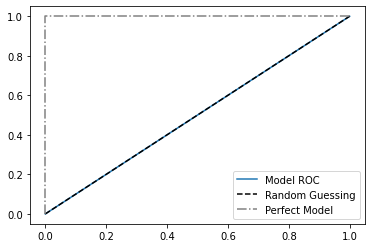

In [135]:
y_pred = svc_pipeline_cv.predict(X_test)
y_prob = svc_pipeline_cv.predict_proba(X_test)
y_prob_1 = y_prob[:, 1]


roc_auc_score(y_test, y_prob_1)




fpr, tpr, thresh = roc_curve(y_test, y_prob_1)

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "-.", c="gray", label="Perfect Model")
plt.legend()
plt.show()

In [136]:
roc_auc_score(y_test, y_prob_1)

0.5

## kNN model

In [137]:
# fmt: off
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ("knn", KNeighborsClassifier()),
])
# fmt: on

grid = {
    "knn__n_neighbors": [4],
}

In [138]:
knn_pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2)
knn_pipeline_cv.fit(X_train_resample, y_train_resample)

print("Best params:")
print(knn_pipeline_cv.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s finished


Best params:
{'knn__n_neighbors': 4}


In [139]:
print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = knn_pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_no_show"],
    columns=["pred_show", "pred_no_show"],
)
display(confusion_df)

print(classification_report(y_test, y_pred))

Train score: 0.570625
Test score: 0.5369649805447471



,pred_show,pred_no_show
actual_show,7129,3159
actual_no_show,2669,1435


              precision    recall  f1-score   support

           0       0.73      0.69      0.71     10288
           1       0.31      0.35      0.33      4104

    accuracy                           0.60     14392
   macro avg       0.52      0.52      0.52     14392
weighted avg       0.61      0.60      0.60     14392



In [140]:
bestThresshold(y_test,y_pred)

(0.3299609105541504, 0.1)

## Logistic Regression

In [141]:
# creating columns for preprocessing

drop_cats = ['JARDIM CAMBURI', 42500000000000]

cat_cols = ['Neighborhood', 'PatientId']

bin_cols = ['Reminder']

num_cols = ['Age']

In [142]:
# dropping Alcoholism, sch_weekday_num and Sex variables based on XGB feature importances

X = df.drop(columns=["show", 'sch_weekday_name', 'appt_weekday_name','Diabetes', 'Hypertension'
                     ,'ScheduledDay', 'AppointmentDay','disability', 'is_male', 'Alcoholism', 'sch_weekday_num'
                     , 'Scholarship', 'day_diff', 'appt_weekday_num', 'Scholarship', 'has_diabetes_and_hyper'])
y = df["show"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [143]:
# Isolating the 2 classes predictors
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

In [144]:
n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

In [145]:
n_0

41149

In [146]:
n_1

16417

In [147]:
n = 20000

In [148]:
# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n, replace=False, random_state=42)

# Sample minority class to have more observations
X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

In [149]:
# Re-combine data (using the downsampled X for majority class)
X_train_resample = pd.concat((X_train_1_sample, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n + [0] * n)

In [150]:
X_train_resample.shape

(40000, 4)

In [151]:
y_train_resample.mean()

0.5

In [152]:
# fmt: off
preprocessing = ColumnTransformer([
    ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='passthrough')
# fmt: on

In [153]:
# fmt: off
pipeline = Pipeline([
    ("preprocessing", preprocessing), 
        ("en", SGDClassifier()),
])
# fmt: on

grid = {
    "en__max_iter": [900, 1000, 1100],
    "en__tol": [0.001, 0.01, 1],
    #"en__alpha" : [0.0001, 0.001],
    #"en__l1_ratio":[.5, .7, .9, .95]
}

In [154]:
en_pipeline_cv = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)
en_pipeline_cv.fit(X_train_resample, y_train_resample)

print("Best params:")
print(en_pipeline_cv.best_params_)

Best params:
{'en__max_iter': 900, 'en__tol': 0.001}


In [155]:
print(f"Train score: {train_score}")
print(f"Test score: {test_score}\n")

y_pred = en_pipeline_cv.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(
    confusion_mat,
    index=["actual_show", "actual_no_show"],
    columns=["pred_show", "pred_no_show"],
)
display(confusion_df)

print(classification_report(y_test, y_pred))

Train score: 0.570625
Test score: 0.5369649805447471



,pred_show,pred_no_show
actual_show,0,10288
actual_no_show,0,4104


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10288
           1       0.29      1.00      0.44      4104

    accuracy                           0.29     14392
   macro avg       0.14      0.50      0.22     14392
weighted avg       0.08      0.29      0.13     14392



C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [156]:
bestThresshold(y_test,y_pred)

(0.4437716262975779, 0.1)

Not sure what I did wrong but my logistid regression model was peforming slightly best compared to all other models but I must have changed something that that resulted in worse train and test scores of .57155 and .55002 with recall of .0 and 1 which is great for predicting no shows but overall now worse that other models. I'll go with XGBoost and move forward.